In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import camelot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [2]:
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def mean_by_cluster(param: str, post_df: pd.DataFrame):
    """
    Compute posterior mean of param by cluster (arrondissement) and category (parties)
    param: parameter to aggregate by cluster. Either "a_district_f" for parameter scale, or "p_district" for outcome scale
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndistricts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Arrondissement"

    for i in range(Ndistricts):
        mean_df[i] = (
            post_df[
                [
                    f"{param}__{i}_0",
                    f"{param}__{i}_1",
                    f"{param}__{i}_2",
                    f"{param}__{i}_3",
                    f"{param}__{i}_4",
                    f"{param}__{i}_5",
                    f"{param}__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_compare_true(
    party_id: int, true_means: np.ndarray, mean_clusters_varying: pd.DataFrame
):
    """
    Compare true proportions and varying-effects estimates.
    If estimates are close to true proportions, it means this model
    looks appropriate
    party_id: from 0 to 6, as there are 7 parties
    """
    plt.figure(figsize=(11, 5))

    plt.plot(
        np.arange(Ndistricts),
        pd.DataFrame(true_means)[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="True proportions",
    )
    plt.plot(
        np.arange(Ndistricts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=8,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xticks(range(Ndistricts), range(1, Ndistricts + 1))
    plt.xlabel("Arrondissement")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [3]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
d = d[d.date != "2017-04-23"].reset_index(drop=True)
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d.tail()

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
55,2014-03-25,Paris,19,46307,3295,19533,5956,0,11932,3678,1913,municipale
56,2017-06-11,Paris,19,50024,9798,4488,5463,18429,3790,2129,5927,legislative
57,2008-05-23,Paris,20,56285,4776,21568,5329,4114,4076,2033,14389,municipale
58,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
59,2017-06-11,Paris,20,57413,11546,10700,7766,6505,4300,2446,14150,legislative


What's the proportion of zeros in the respective categories?

In [182]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.0
left        0.0
green       0.5
center      0.0
right       0.0
farright    0.0
other       0.0
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

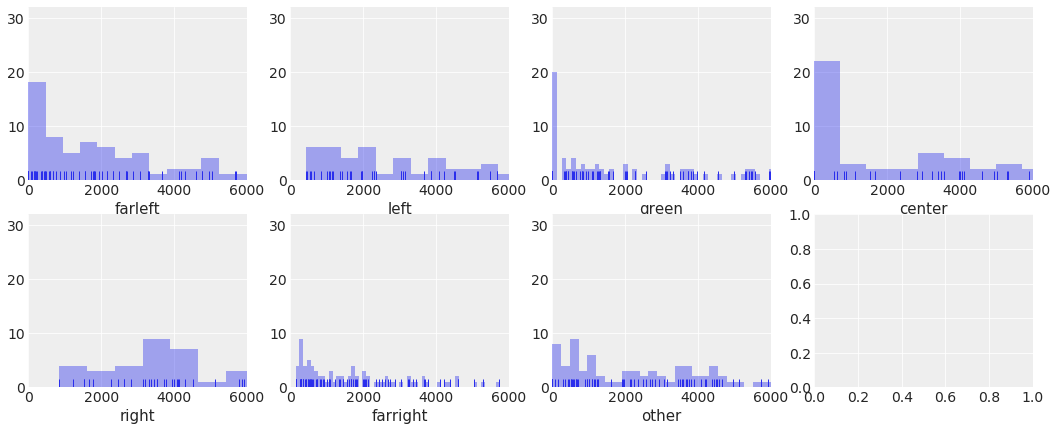

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts. Now, how can we model this mixed process?

First, let's define index variables:

In [4]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values  # for the real model

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [5]:
pred = pd.read_excel(
    "data/chomage-zone-demploi-2003-2019.xls", header=5, sheet_name="txcho_ze"
)
pred = pred[pred["LIBZE2010"] == "Paris"].iloc[:, 4:].T
pred.columns = ["unemployment"]

# as timestamps variables:
pred.index = pd.PeriodIndex(start=pred.index[0], periods=len(pred), freq="Q")
pred

,unemployment
2003Q1,8.4
2003Q2,8.7
2003Q3,8.6
2003Q4,9.0
2004Q1,9.2
...,...
2018Q1,7.9
2018Q2,7.8
2018Q3,7.8
2018Q4,7.4


In [6]:
tables = camelot.read_pdf("data/real_estate_paris.pdf", pages="all", strip_text=" €")

prices = pd.concat(
    [tables[0].df.iloc[1:], tables[1].df.iloc[1:]], axis=0, ignore_index=True
)
prices.index = pd.PeriodIndex(start="2000Q4", periods=len(prices), freq="Q",)[::-1]
prices.index.name = "quarter"
prices.columns.name = "arrondissement"

prices = prices.drop(0, axis=1).sort_index().astype(float)
prices = prices.unstack()
prices.name = "prices"
prices

arrondissement  quarter
1               2000Q4     3500.0
                2001Q1     3780.0
                2001Q2     3930.0
                2001Q3     4150.0
                2001Q4     3940.0
                            ...  
20              2018Q2     7930.0
                2018Q3     8230.0
                2018Q4     8080.0
                2019Q1     8220.0
                2019Q2     8350.0
Name: prices, Length: 1500, dtype: float64

In [7]:
# add quarters to original dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"

# merge with unemployment (same for whole city):
d = (
    d.join(pred)
    .sort_values(["arrondissement", "date"])
    .reset_index()
    .set_index(["arrondissement", "quarter"])
)

# merge with real estate prices (different for each district):
d = d.join(prices).reset_index().drop("quarter", axis=1)

# standardize predictors:
d["log_unemp"] = stdz(np.log(d["unemployment"].values))
d["prices"] = stdz(d["prices"])
d.tail()

,arrondissement,date,ville,N,farleft,left,green,center,right,farright,other,type,unemployment,prices,log_unemp
55,19,2014-03-25,Paris,46307,3295,19533,5956,0,11932,3678,1913,municipale,8.7,-1.014012,1.056390
56,19,2017-06-11,Paris,50024,9798,4488,5463,18429,3790,2129,5927,legislative,8.0,-0.864864,0.286071
57,20,2008-05-23,Paris,56285,4776,21568,5329,4114,4076,2033,14389,municipale,6.7,-1.713857,-1.342462
58,20,2014-03-25,Paris,54966,5692,20502,5990,0,11467,4112,7203,municipale,8.7,-0.905019,1.056390
59,20,2017-06-11,Paris,57413,11546,10700,7766,6505,4300,2446,14150,legislative,8.0,-0.715717,0.286071


Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [143]:
with pm.Model() as m_real:
    mus_parties = []
    log_unemp = pm.Data("log_unemp", d.log_unemp.values)
    price = pm.Data("price", d.prices.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_unemp
            + ab_district[district_id, 2] * price
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 6 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
INFO:pymc3:NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 4 divergences: 100%|██████████| 8000/8000 [1:14:12<00:00,  1.80draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergen

In [8]:
with pm.Model() as m_real:
    mus_parties = []
    price = pm.Data("price", d.prices.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=2, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=2, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=2, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}", mu=np.array([-1.8, 0.0]), sd=np.array([0.1, 0.5]), shape=2,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 2)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0] + ab_district[district_id, 1] * price
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

with open("trace_prices.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [24:01<00:00,  5.55draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [7]:
with open("trace_real2.pkl", "rb") as f:
    data = pickle.load(f)
m_real, trace_real = data["model"], data["trace"]
post_real = pm.trace_to_dataframe(trace_real)

In [9]:
az.summary(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab_p0[0],-1.82,0.10,-2.01,-1.63,0.00,0.00,3868.59,3858.14,3897.10,1293.35,1.0
ab_p0[1],-0.47,0.40,-1.19,0.36,0.01,0.01,3660.59,1892.80,3685.14,1164.72,1.0
ab_p1[0],-1.78,0.10,-1.98,-1.60,0.00,0.00,3564.25,3512.11,3576.04,1494.57,1.0
ab_p1[1],-1.16,0.35,-1.80,-0.48,0.01,0.00,2507.83,2507.83,2570.90,1583.04,1.0
ab_p2[0],-1.81,0.10,-1.99,-1.64,0.00,0.00,3079.64,3075.76,3086.98,1586.20,1.0
ab_p2[1],-0.95,0.28,-1.44,-0.41,0.00,0.00,3150.18,3150.18,3237.91,1564.74,1.0
ab_p3[0],-1.73,0.10,-1.91,-1.55,0.00,0.00,3129.45,3110.79,3180.48,1427.34,1.0
ab_p3[1],0.24,0.32,-0.39,0.79,0.01,0.01,3477.42,1902.38,3497.12,1640.99,1.0
ab_p4[0],-1.76,0.09,-1.93,-1.58,0.00,0.00,3152.61,3152.61,3161.22,1397.93,1.0
ab_p4[1],-0.77,0.35,-1.43,-0.13,0.01,0.00,3668.35,3423.17,3735.22,1530.36,1.0


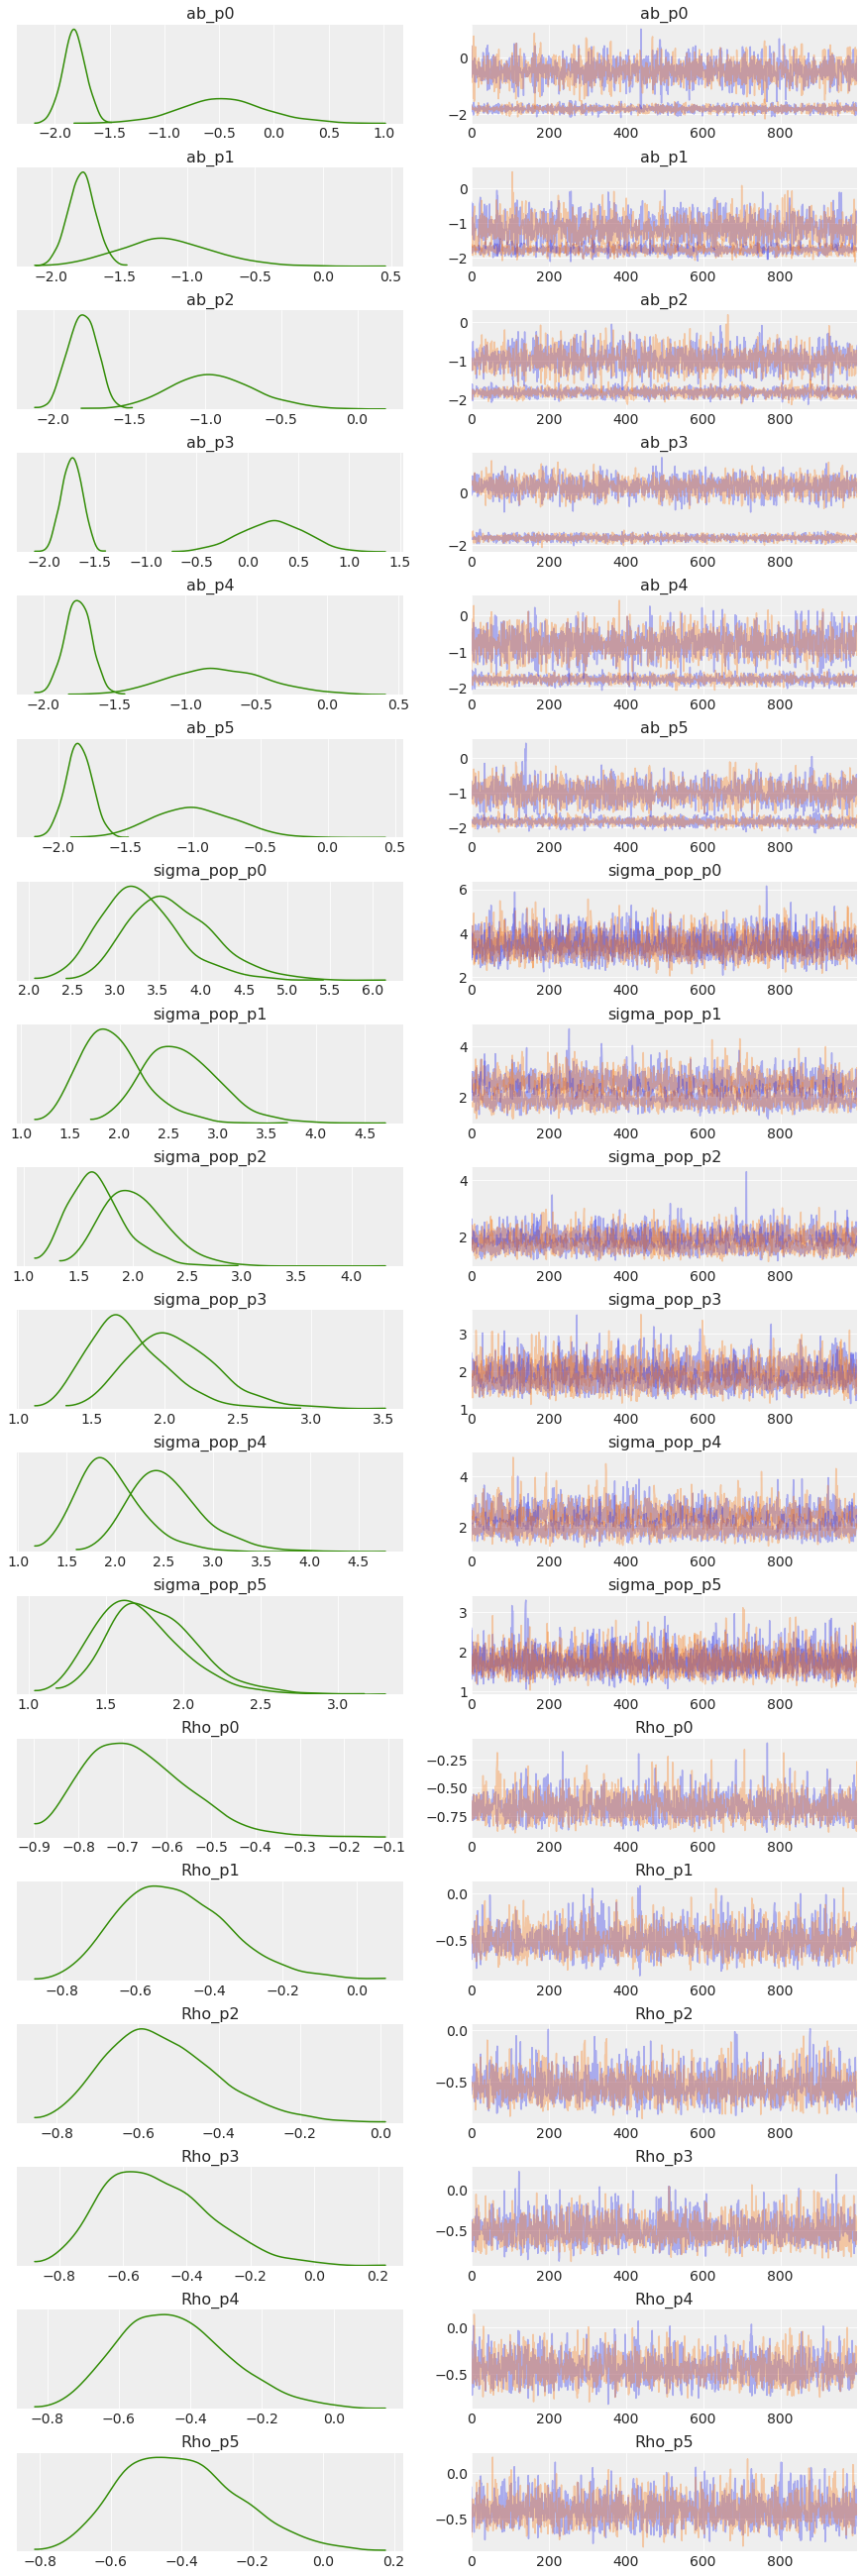

In [10]:
az.plot_trace(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    compact=True,
    combined=True,
)

Everything looks fine. Now let's tackle posterior predictive checks! We'll draw two types of PPC here, starting by what Richard McElreath calls "**counterfactual plots**". These show how predictions change when the one predictor in our model varies, even when this predictor takes unreal values -- hence "counterfactual". 

So, we are going to sample posterior predictive probabilities from the model, with new `unemployment` values. This means we get 4000 samples for each party's probability, in each district, under the new counterfactual conditions. The plots then display the change in probability across values of the predictor of interest and... tadaaaa!

In [21]:
# counterfactuals for a given district:
d_id = np.random.randint(0, Ndistricts)
predictor_seq = np.linspace(-3, 4)
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, d_id, 0]
            + trace_real[f"ab_district_p{p}"][:, d_id, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000)

In [22]:
# append last category:
mus_other = np.full(shape=(1, mus_pp.shape[1], mus_pp.shape[2]), fill_value=-2.2)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000)

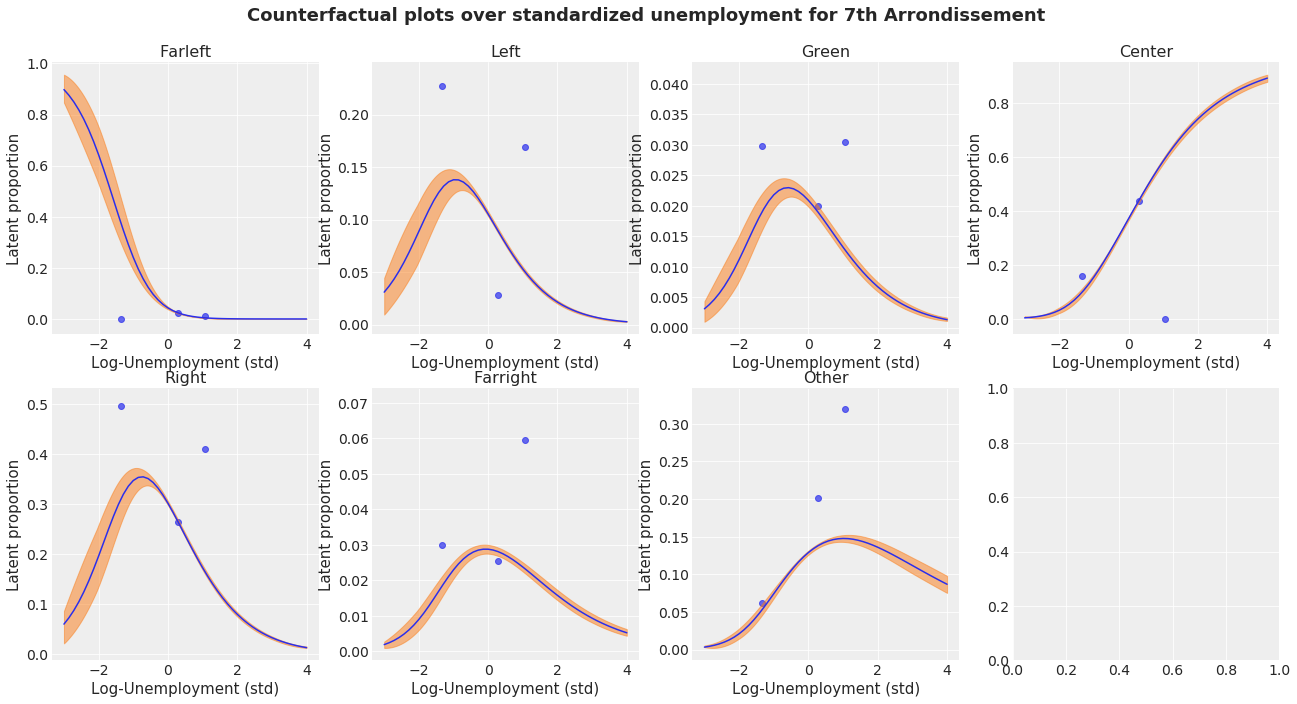

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            col.scatter(
                d.loc[d.arrondissement == d_id + 1, "log_unemp"],
                d.loc[d.arrondissement == d_id + 1, f"{PARTIES[i]}"]
                / d.loc[d.arrondissement == d_id + 1, "N"],
                alpha=0.7,
            )
            col.plot(predictor_seq, prob_mean[i, :])
            az.plot_hpd(predictor_seq, prob_pp[i, :, :].T, ax=col)
            col.set_xlabel("Log-Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Counterfactual plots over standardized log-unemployment for {d_id + 1}th Arrondissement",
    y=0.95,
    size=18,
    weight="bold",
);

In [25]:
# counterfactuals for all districts:
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, :, 0]
            + trace_real[f"ab_district_p{p}"][:, :, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000, 20)

In [26]:
# append last category:
mus_other = np.full(
    shape=(1, mus_pp.shape[1], mus_pp.shape[2], mus_pp.shape[3]), fill_value=-2.2
)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000, 20)

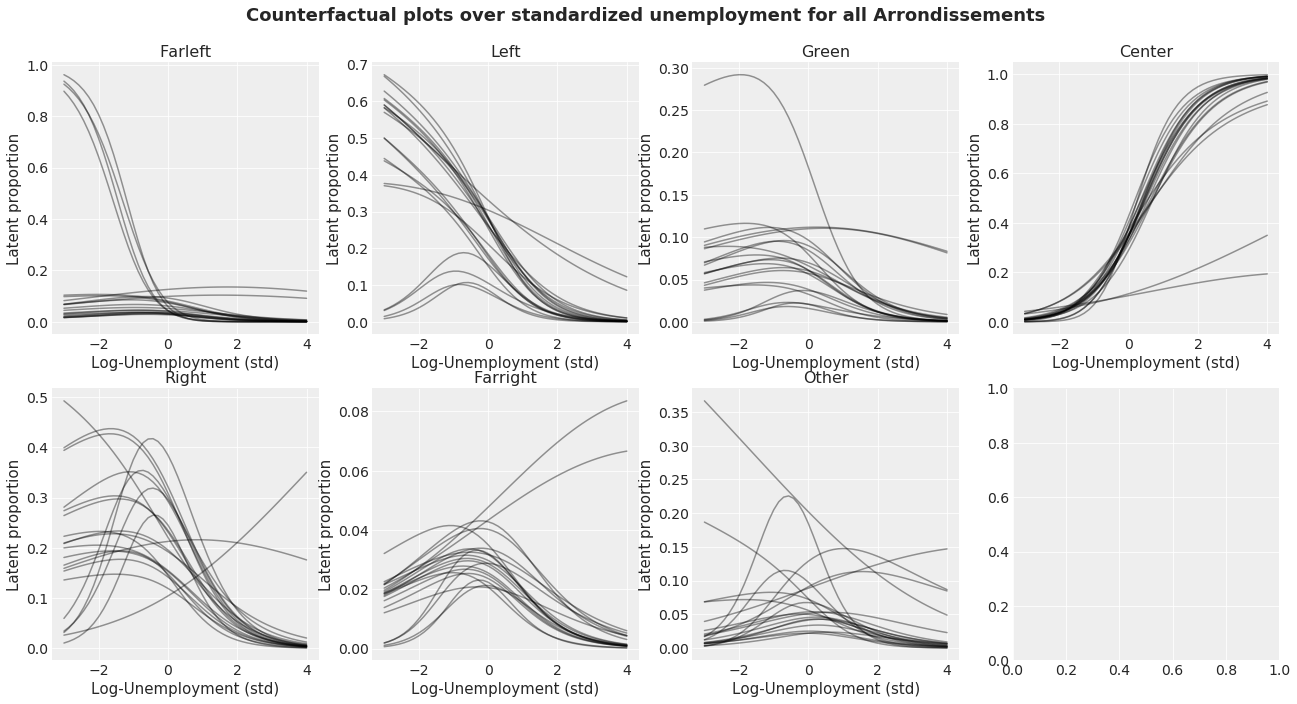

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            for dis in range(Ndistricts):
                col.plot(predictor_seq, prob_mean[i, :, dis], "k", alpha=0.4)
            col.set_xlabel("Log-Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    "Counterfactual plots over standardized log-unemployment for all Arrondissements",
    y=0.95,
    size=18,
    weight="bold",
);

These plots help us understand the model's implications. As seen in the summary table, the only reliably positive slope is for the centrist party, while the only reliably negative one is for the far left party. This means that when unemployment increases, so does the centrist party's share, on average, while the farl left's decreases. For other parties, the effect of unemployment seems more ambiguous, helping then hurting them when unemployment reaches 0 (its mean value). 

Don't forget however that these effects are contingent on the district we're looking at -- some districts may react more to unemployment than others -- and, as slopes and intercepts are correlated, the variation is multi-dimensional -- yeah, it's a complicated model and the best way to understand it is to plot what it's telling us on the outcome space, as we did here.

Keep in mind though that these predictons are *counterfactual*: they display predictions for sometimes impossible values of the predictor - unrealistically high or low unemployment rates. Also, here we show the raw, observed proportions for each party, but the lines depict the *latent* probabilities -- which we don't get to observe. So, if the fit is not perfect, it's because it's normal. First, the model is trying to infer the latent probabilities from the observed, zero-inflated proportions, which inevitably leads to differences. Second, we should't expect perfect fit in-sample, because the model pools information among intercepts and slopes -- which reduces in-sample fit to improve out-of-sample predictions.

However, it's interesting to compare the model's predictions against raw data. Let's do that, now that we have a better understanding of the posterior distribution. The idea is to plot predictions against observed data, to see if the model correctly approximates the posterior distribution, and where the model fails. That's what the appropriately named "**posterior predictive plots**" do. We'll begin with in-sample predictions (what does the model say about the elections it learned on) and will go on with out-of-sample predictions of the European 2019 elections:

In [28]:
share_est = parties_available * trace_real["lat_p"]
share_est = share_est / np.sum(share_est, axis=2, keepdims=True)
share_mean = share_est.mean(0)

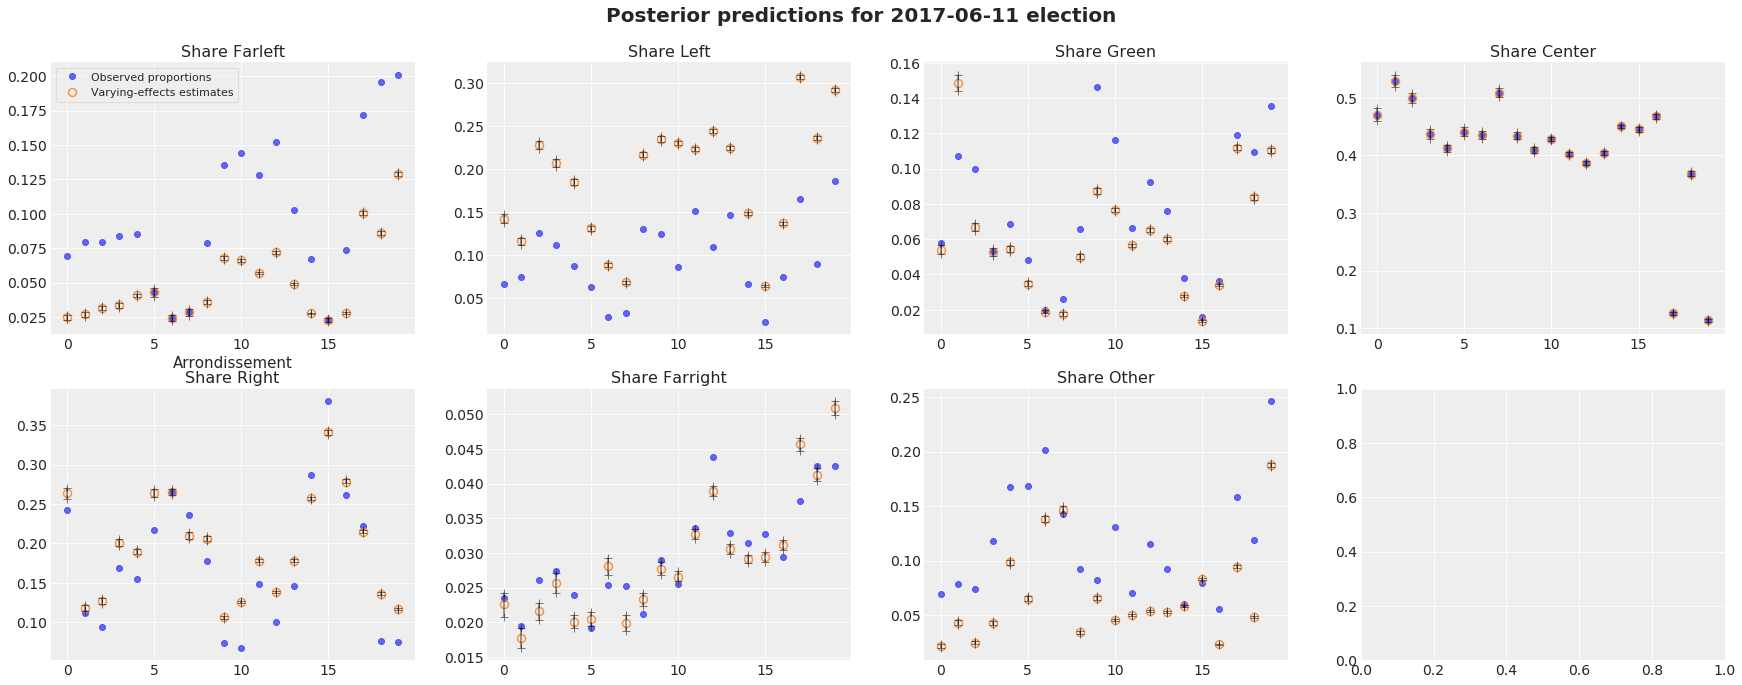

In [31]:
election = "2017-06-11"
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
i = 0
for line in axes:
    for col in line:
        try:
            col.plot(
                np.arange(Ndistricts),
                d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
                "o",
                ms=6,
                alpha=0.7,
                label="Observed proportions",
            )
            col.plot(
                np.arange(Ndistricts),
                share_mean[election_mask, i],
                "o",
                fillstyle="none",
                ms=8,
                markeredgewidth=1.5,
                alpha=0.8,
                label="Varying-effects estimates",
            )
            col.plot(
                [np.arange(Ndistricts), np.arange(Ndistricts)],
                az.hpd(share_est[:, election_mask, i]).T,
                "k-+",
                ms=8,
                alpha=0.5,
            )
            col.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
            col.set_title(f"Share {PARTIES[i].title()}")
            if i == 0:
                col.set_xlabel("Arrondissement")
                col.legend(frameon=True, framealpha=0.5, fontsize=11)
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Posterior predictions for {election} election", y=0.95, size=20, weight="bold",
);

Because of shrinkage, we don't expect the posterior to just repeat the data -- the whole point of varying-effects is to trade-off worse fit in-sample for better predictions out-of-sample. Here is however, the model seems to be too far off for most parties, especially for the left and far left parties. Something is influencing these parties' scores that we didn't include in the model yet.

Interestingly, the model is very good at grasping the trend for the centrist party. Remember that center is the only party that has a clear linear relationship with unemployment, so this could be an explanation. In other words, if we want to improve the model's performance, we should find other predictors that inform us better about the other parties -- as unemployment informs us about the centrist party.

And just in case you're doubting, it *is* useful to have unemployment in the model, although only center really benefits from it. If we run the intercept-only model, you'll see that its posterior predictions are even worse than the covariance model.

In [ ]:
# new preds (real estate, GDP nat., popu. PR nat.), add elections, new clusters (type elec, date elec), measurement error on preds
# IMMOBILIER: https://basebien.com/PNSPublic/DocPublic/HistoriquedesprixaumappartementsanciensParispararrdt.pdf, https://m2paris.fr/ et http://paris.notaires.fr/fr/carte-des-prix
# http://opendata.apur.org/datasets/recensement-commune-emploi?geometry=1.789%2C48.751%2C2.942%2C48.909

# https://www.apur.org/dataviz/portraits-metropole-grand-paris-donnees/
# https://www.insee.fr/fr/statistiques?debut=0&geo=COM-75056&idfacette=3
# https://www.data.gouv.fr/fr/territories/departement/75@1968-01-01/Paris/
# https://datafrance.info/paris-1er-arrondissement-75001/population/categories-socioprofessionnelles?view=pie

# euro2019
# shrinkage, nocov